In [1]:
import numpy as np
import sys
from math import *

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import image
from matplotlib import ticker
from cycler import cycler

%matplotlib inline

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')

import geom
import transducers
import sonalleve
import RSgpuPySwig

import PBHE_CUDA
import sys
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import importlib

np.set_printoptions(precision=4, suppress=False, threshold=1300)
plt.rc('axes.formatter',useoffset=False)

plt.rc('axes',prop_cycle=(cycler('color', ['b', 'g', 'r', (0,.8,.8),(.8,0,.8), (.5,.5,.5), (.3, .3,0), (.1,.3,0.5), (.8,.4,0.1), (.1,0.9,0.3)])) )

In [2]:
importlib.reload(ablation_utils)

<module 'ablation_utils' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\ablation_utils.py'>

In [2]:
f0=1.2e6
c0=1540
rho=1000
Cp=3700
ktherm=0.6

Ispta0=1.0e7

T0=37
k0 = 2*pi*f0/c0

xw=2.0
yw=2.0
zmin=11.0
zmax=16.0

Nt=50
Nx=64
Ny=64
Nz=64

dataType = np.float32

simgrid = ablation_utils.makeSimPhysGrid(nt=Nt,nx=Nx,ny=Nz,nz=Nz,rho=rho,ktherm=ktherm,f0=f0,Cp=Cp,c0=c0,
    dt=0.1, xr=[-xw/2.0, xw/2.0], yr=[-yw/2.0, yw/2.0],zr=[zmin,zmax])


CEMfinal =np.zeros([Nx,Ny,Nz],dtype=dataType)
Rbase=np.zeros([Nx,Ny,Nz],dtype=dataType)
Tmax=np.zeros([Nx,Ny,Nz],dtype=dataType)

[T4d,tdot3d,kt3d,rhoCp3d,Dtxyz]=[simgrid[k] for k in tuple('T,Tdot,kt,rhoCp,dtxyz'.split(','))]

[xrp,yrp,zrp]=[simgrid[k] for k in tuple('xrp,yrp,zrp'.split(','))]
(dx,dy,dz,dt)=simgrid['dtxyz']

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)


voxml = dx*dy*dz*1e6

In [5]:
import timeit

In [13]:
def testgpu():
    transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, np.ones(N) / N, xrp, yrp, zrp, **RSkeys   )
    
    
    
def testcpu():
    transducers.calc_pressure_field(k0, uxyz, unvecs, np.ones(N) / N, xrp, yrp, zrp  )


In [12]:
testgpu()

In [18]:
s="testgpu()"
timeit.timeit(stmt=s,setup="",number=1)

NameError: name 'testgpu' is not defined

In [17]:
simgrid['dtxyz']

array([ 0.1       ,  0.00031746,  0.00031746,  0.00079364], dtype=float32)

In [3]:
def L2norm(arg):
    return np.sqrt(np.sum(np.abs(arg)**2))


uxyz = sonalleve.get_sonalleve_xdc_vecs()
N = uxyz.shape[0]

unvecs = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)), 1, [0.0,0.0,0.14] - uxyz )

uamp0 = np.ones(N) / N

#P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, np.linspace(-0.003,0.003,60), np.linspace(-0.003,0.003,60), 0.14 + np.linspace(-0.003,0.003,60))

RSkeys=dict(subsampN=10, ROC=0.14, subsampDiam=0.0066, gpublocks=512)


P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, np.linspace(-0.003,0.003,60), np.linspace(-0.003,0.003,60), 0.14 + np.linspace(-0.003,0.003,60),  
                                         **RSkeys)

I0 = np.abs(P0)**2 / (2.0*rho*c0)
#powerRenormL1 = (Ispta0/np.max(I0))

calibrationGain = (Ispta0/np.max(I0))
L2powRenorm = sqrt(calibrationGain)*L2norm(uamp0)


In [4]:
def inSphere(x,y,z,r=0.005): 
    return np.sqrt(x**2 + y**2 + z**2)<=r
    
def inEllipse(x,y,z,a=0.005,b=0.005,c=0.005):
    return np.sqrt((x/a)**2 + (y/b)**2 + (z/c)**2)<=1.0
    
def roiGen(focalPattern, isContainedFunc):
    """
    focalPattern is an (m x 3) array
    """
    nf = len(focalPattern)
    mask=np.zeros_like(gxp,dtype=bool)
    for i in range(0,nf):
        mask= np.logical_or( mask, isContainedFunc(gxp - focalPattern[i][0], gyp - focalPattern[i][1], gzp - focalPattern[i][2]) )
    return mask

In [5]:


nfociList = [2,3,4,5,6,7]
nfociList = [1,2,3,4,5,6,7,8,9,10]
#nfociList = [1,3,5]
nftrials = len(nfociList)

diamList= (np.arange(0.001,0.01001,0.00025))
#diamList=np.array([0.001, 0.0045])

ndtrials=len(diamList)

lesionRatesON = np.zeros([nftrials,ndtrials])
lesionRatesEXTRA = np.zeros([nftrials,ndtrials])
lesionRatesAllSpace = np.zeros([nftrials,ndtrials])

TavgRatesON = np.zeros([nftrials,ndtrials])
TavgRatesOFF = np.zeros([nftrials,ndtrials])
TmaxON = np.zeros([nftrials,ndtrials])
TmaxOFF = np.zeros([nftrials,ndtrials])
TmaxSet= np.zeros([nftrials,ndtrials])
TavgVsZ= np.zeros([nftrials,ndtrials,len(zrp)])
TWm1Set= np.zeros([nftrials,ndtrials])
TWm2Set= np.zeros([nftrials,ndtrials])

In [268]:

T4d[0][:] = T0

In [426]:
transducers.new_stipled_spherecap_array(0.14,.1,40)

[array([[ 0.    ,  0.    ,  0.    ],
        [ 0.0254,  0.    ,  0.0023],
        [ 0.0159,  0.0199,  0.0023],
        [-0.0057,  0.0248,  0.0023],
        [-0.0229,  0.011 ,  0.0023],
        [-0.0229, -0.011 ,  0.0023],
        [-0.0057, -0.0248,  0.0023],
        [ 0.0159, -0.0199,  0.0023],
        [ 0.05  ,  0.    ,  0.0092],
        [ 0.0443,  0.0232,  0.0092],
        [ 0.0284,  0.0411,  0.0092],
        [ 0.006 ,  0.0496,  0.0092],
        [-0.0177,  0.0468,  0.0092],
        [-0.0374,  0.0332,  0.0092],
        [-0.0485,  0.012 ,  0.0092],
        [-0.0485, -0.012 ,  0.0092],
        [-0.0374, -0.0332,  0.0092],
        [-0.0177, -0.0468,  0.0092],
        [ 0.006 , -0.0496,  0.0092],
        [ 0.0284, -0.0411,  0.0092],
        [ 0.0443, -0.0232,  0.0092]]), 21]

In [6]:
def execute_sim(M,d, sonication_time=1.0, Tmax=None, alpha=1.0):
    #d = diamList[di]
    if M==1:
        spacing=0
        pxyz=np.array([[0.0, 0.0, 0.14]])
        radius=d/2
    else:
        pxyz,radius = geom.ring(d,M,z=0.14)
        spacing = 2*(radius**2)*(1 - cos(2*pi/M))

    #ROION=   roiGen(pxyz, lambda x,y,z: inEllipse(x,y,z,0.001,0.001,0.01) )
    #ROION=   roiGen([[0,0,0.14]], lambda x,y,z: inEllipse(x,y,z, radius + 0.002, radius + 0.002,2*2*radius))
    ROION=   roiGen([[0,0,0.14]], lambda x,y,z: inEllipse(x,y,z, 0.006, 0.006,0.01))
    
    ROIEXTRA=roiGen(pxyz, lambda x,y,z: inEllipse(x,y,z,0.01,0.01,0.04) )
    ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))

    #uamp = transducers.get_focused_element_vals( k0,uxyz,pxyz,1e7*np.ones(M), L1renorm=sqrt(powerRenormL1) )
    
    #uamp = transducers.get_focused_element_vals( k0,uxyz,pxyz,1e7*np.ones(M)*np.exp(1j*np.arange(0,M)*pi), L1renorm=sqrt(powerRenormL1) )
    uamp = transducers.get_focused_element_vals( k0,uxyz,pxyz, np.ones(M)*np.exp(1j*np.arange(0,M)*pi), L2renorm=L2powRenorm )
    
    P1 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, **RSkeys   )
    I1 = np.abs(P1)**2 / (2.0*rho*c0)
    tdot3d[:] = 2*alpha*I1 / (rhoCp3d)
    (duration,Tmax,junk,junk) = ablation_utils.calc_heating(simgrid,T4d,tdot3d, simgrid['Tmesh'], simgrid['Tdotmesh'], simgrid['kmesh'], simgrid['rhoCpmesh'], sonication_time, CEMfinal,Rbase,   
                                                      Tmax=Tmax, Ntbuff=Nt, GPU=False, Freeflow=1)
    return (duration,Tmax, ROION, ROIOFF, ROIEXTRA)

In [10]:
uamp = transducers.get_focused_element_vals( k0,uxyz,[[0.0, 0.0, 0.14]],1e7*np.ones(1)*np.exp(1j*np.arange(0,1)*pi), L1renorm=sqrt(powerRenormL1) )

P1 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, **RSkeys   )

In [12]:
#PBHE_CUDA.Create_Global_GPU_Session32(*T4d.shape)
#PBHE_CUDA.Create_Global_GPU_Session64(*T4d.shape)
sonication_time=15.0
alpha=3.0
for mi in range(0,nftrials):
    M = nfociList[mi]
    print('#nfoc=',M,flush=True)
    for di in range(0,ndtrials):
        
        T4d[0][:] = T0
        CEMfinal[:] = 0
        Tmax[:] = 0
        
        d = diamList[di]
        print(d,end=' ',flush=True)
        if M==1 and di>0:
            lesionRatesAllSpace[mi,di] = lesionRatesAllSpace[mi,di-1]
            lesionRatesON[mi,di] = lesionRatesON[mi,di-1]
            lesionRatesEXTRA[mi,di] = lesionRatesEXTRA[mi,di-1]
            TavgRatesON[mi,di] = TavgRatesON[mi,di-1]
            TavgRatesOFF[mi,di] = TavgRatesOFF[mi,di-1]
            TWm1Set[mi,di] = TWm1Set[mi,di-1]
            TWm2Set[mi,di] = TWm2Set[mi,di-1]
            TmaxSet[mi,di] = TmaxSet[mi,di-1]
            TmaxON[mi,di] = TmaxON[mi,di-1]
            TmaxOFF[mi,di] = TmaxOFF[mi,di-1]
            TavgVsZ[mi,di,:] = TavgVsZ[mi,di-1,:]
        else:
            (duration,Tmax, ROION, ROIOFF, ROIEXTRA) = execute_sim(M,d,sonication_time=sonication_time,Tmax=Tmax, alpha=alpha)
        
            lesionRatesAllSpace[mi,di] = np.sum(CEMfinal >= 240.0) * voxml / duration
            lesionRatesON[mi,di] = np.sum(CEMfinal[ROION] >= 240.0) * voxml / duration
            lesionRatesEXTRA[mi,di] = np.sum(CEMfinal[ROIEXTRA] >= 240.0) * voxml / duration
            TavgRatesON[mi,di] = np.mean(Tmax[ROION])
            TavgRatesOFF[mi,di] = np.mean(Tmax[ROIOFF])
            TmaxON[mi,di] = np.max(Tmax[ROION])
            TmaxOFF[mi,di] = np.max(Tmax[ROIOFF])
            
            TWnorm=np.sum(Tmax)
            TWcentroid=list(map(np.sum, [Tmax/TWnorm*gxp, Tmax/TWnorm*gyp, Tmax/TWnorm*gzp] ))
            TWm1=np.sum( Tmax/TWnorm*np.sqrt((gxp-TWcentroid[0])**2 + (gyp-TWcentroid[1])**2 + (gzp-TWcentroid[2])**2)  )
            TWm2=np.sum( Tmax/TWnorm*((gxp-TWcentroid[0])**2 + (gyp-TWcentroid[1])**2 + (gzp-TWcentroid[2])**2)  )
            
            
            TWm1Set[mi,di]= TWm1
            TWm2Set[mi,di]= TWm2
            
            TavgVsZ[mi,di,:]= np.mean(Tmax,axis=(0,1))
            TmaxSet[mi,di]= np.max(Tmax)
     
    print('\n')
#PBHE_CUDA.ResetGPU()

#nfoc= 1
0.001 0.00125 0.0015 0.00175 0.002 0.00225 0.0025 0.00275 0.003 0.00325 0.0035 0.00375 0.004 0.00425 0.0045 0.00475 0.005 0.00525 0.0055 0.00575 0.006 0.00625 0.0065 0.00675 0.007 0.00725 0.0075 0.00775 0.008 0.00825 0.0085 0.00875 0.009 0.00925 0.0095 0.00975 0.01 

#nfoc= 2
0.001 0.00125 0.0015 0.00175 0.002 0.00225 0.0025 0.00275 0.003 0.00325 0.0035 0.00375 0.004 0.00425 0.0045 0.00475 0.005 0.00525 0.0055 0.00575 0.006 0.00625 0.0065 0.00675 0.007 0.00725 0.0075 0.00775 0.008 0.00825 0.0085 0.00875 0.009 0.00925 0.0095 0.00975 0.01 

#nfoc= 3
0.001 0.00125 0.0015 0.00175 0.002 0.00225 0.0025 0.00275 0.003 0.00325 0.0035 0.00375 0.004 0.00425 0.0045 0.00475 0.005 0.00525 0.0055 0.00575 0.006 0.00625 0.0065 0.00675 0.007 0.00725 0.0075 0.00775 0.008 0.00825 0.0085 0.00875 0.009 0.00925 0.0095 0.00975 0.01 

#nfoc= 4
0.001 0.00125 0.0015 0.00175 0.002 0.00225 0.0025 0.00275 0.003 0.00325 0.0035 0.00375 0.004 0.00425 0.0045 0.00475 0.005 0.00525 0.0055 0.00575 0.006 0.00625 0

C:\Users\Vandiver\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


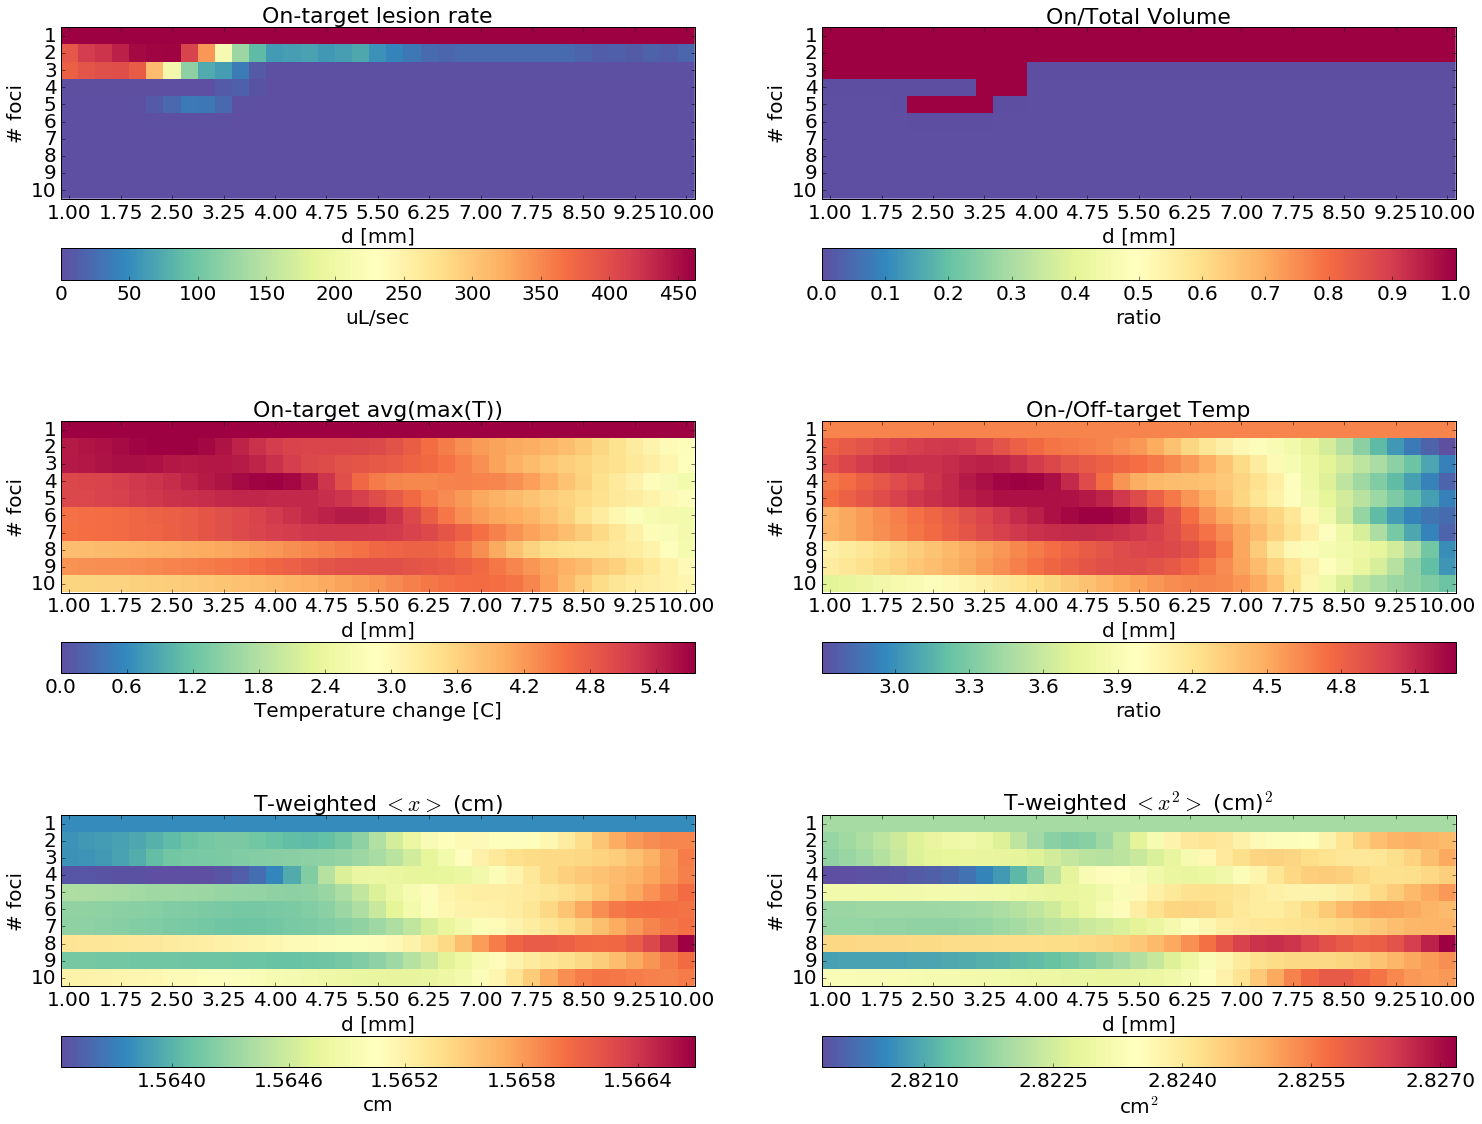

In [13]:
#lesionRatesEXTRA - lesionRatesON


zeroMask=lesionRatesEXTRA==0

onExtraVolratio = lesionRatesON/lesionRatesEXTRA
onExtraVolratio[zeroMask]=0

plt.figure(figsize=(25,20))

cmm=image.cm.Spectral_r

ax=plt.subplot(3,2,1)
maxmlRate=np.max(lesionRatesAllSpace)
plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
dSpc = (diamList[-1] - diamList[-2])
#bounds = [ 1000*(diamList[0] + dSpc/2), 1000*(diamList[-1] + dSpc/2 + dSpc ) , nfociList[-1]+1, nfociList[0] ]
plt.imshow( lesionRatesON*1000 , vmin=0,vmax=maxmlRate*1000, interpolation='None',cmap=cmm )

ax.set_title("On-target lesion rate",fontsize=22)

dstep=3
diamStr = list(map(lambda d:"%0.2f" % d,1000*diamList[0:ndtrials:dstep]))
diamLocs= np.arange(0.0, ndtrials,dstep)

cb=plt.colorbar(orientation='horizontal')
cb.set_label('uL/sec',fontsize=20)
cb.ax.tick_params(labelsize=20)

ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )
ax.tick_params(labelsize=20)



ax=plt.subplot(3,2,2)
ax.set_title("On/Total Volume",fontsize=22)

ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )

plt.imshow( onExtraVolratio,interpolation='None',cmap=cmm )

cb=plt.colorbar(orientation='horizontal')
cb.set_label('ratio',fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)



ax=plt.subplot(3,2,3)
ax.set_title("On-target avg(max(T))",fontsize=22)
ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )

plt.imshow( TavgRatesON-T0,vmin=0,interpolation='None',cmap=cmm )
plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)

cb=plt.colorbar(orientation='horizontal')
cb.set_label('Temperature change [C]',fontsize=20)
cb.ax.tick_params(labelsize=20)



ax=plt.subplot(3,2,4)

ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )
ax.set_title("On-/Off-target Temp",fontsize=22)
plt.imshow( (TavgRatesON-T0) / (TavgRatesOFF-T0),interpolation='None',cmap=cmm )
#plt.imshow( ((TavgRatesON)/(TavgRatesOFF)) ,interpolation='None',cmap=cmm )
cb=plt.colorbar(orientation='horizontal')
cb.set_label('ratio',fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)

ax=plt.subplot(3,2,5)

ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )
ax.set_title("T-weighted $<x>$ (cm)",fontsize=22)
plt.imshow( TWm1Set*100 ,interpolation='None',cmap=cmm )

cb=plt.colorbar(orientation='horizontal')
cb.set_label('cm',fontsize=20)
cb.ax.tick_params(labelsize=20)
cb.locator = ticker.MaxNLocator(nbins=6)
#cb.formatter = ticker.EngFormatter()
cb.update_ticks()

plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)

ax=plt.subplot(3,2,6)

ax.xaxis.set_agg_filter
ax.xaxis.set_ticks( diamLocs )
ax.xaxis.set_ticklabels( diamStr )

ax.yaxis.set_ticks( np.arange(0.0, nftrials) )
ax.yaxis.set_ticklabels( nfociList )
ax.set_title("T-weighted $<x^2>$ (cm)$^2$",fontsize=22)
ax.tick_params(labelsize=20)


plt.imshow( TWm2Set*1e4 ,interpolation='None',cmap=cmm )

cb=plt.colorbar(orientation='horizontal')

cb.set_label('cm$^2$',fontsize=20)
cb.ax.tick_params(labelsize=20)
cb.locator = ticker.MaxNLocator(nbins=6)
#cb.formatter = ticker.EngFormatter()
cb.update_ticks()


plt.xlabel('d [mm]', fontsize=20)
plt.ylabel('# foci', fontsize=20)
ax.tick_params(labelsize=20)


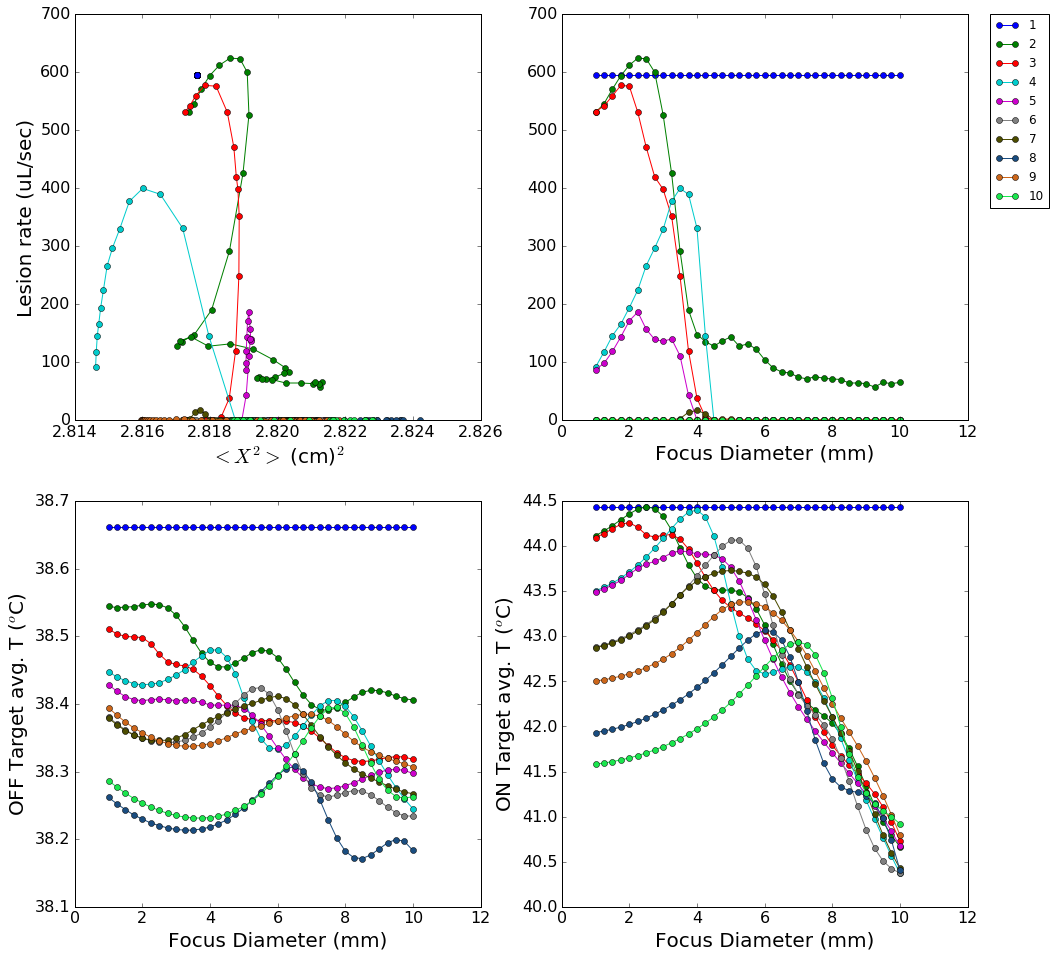

In [9]:
fig=plt.figure(figsize=(16,16))
ax=plt.subplot(221)
pp=ax.plot( TWm2Set.transpose()*1e4, lesionRatesAllSpace.transpose()*1e3,'-o' )

ax.set_xlabel('$<X^2>$ (cm)$^2$', fontsize=20)
ax.set_ylabel('Lesion rate (uL/sec)', fontsize=20)
ax.tick_params(labelsize=16)

ax=plt.subplot(222)
diams=1000*np.repeat( diamList,len(nfociList),axis=0 ).reshape([len(diamList),len(nfociList)])
pp=ax.plot( diams, lesionRatesAllSpace.transpose()*1e3, '-o' )

ax.set_xlabel('Focus Diameter (mm)', fontsize=20)
ax.tick_params(labelsize=16)
ax.legend( nfociList,bbox_to_anchor=(1.20, 1.0), borderaxespad=0.)


ax=plt.subplot(223)
pp=ax.plot( diams, (TavgRatesOFF).transpose(),'-o' )

ax.set_xlabel('Focus Diameter (mm)', fontsize=20)
ax.set_ylabel('OFF Target avg. T ($^o$C)', fontsize=20)
ax.tick_params(labelsize=16)

ax=plt.subplot(224)
pp=ax.plot( diams, TavgRatesON.transpose(),'-o' )

ax.set_xlabel('Focus Diameter (mm)', fontsize=20)
ax.set_ylabel('ON Target avg. T ($^o$C)', fontsize=20)
ax.tick_params(labelsize=16)


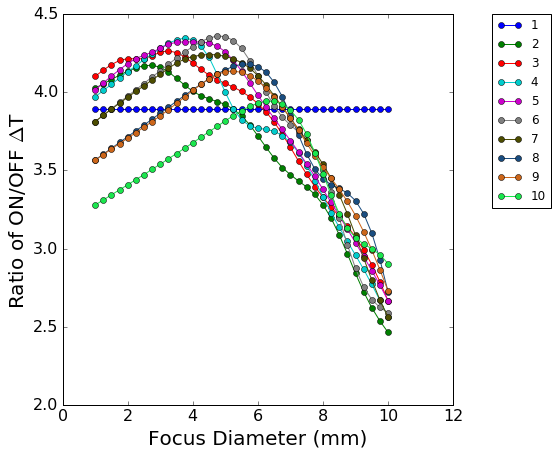

In [10]:
fig=plt.figure(figsize=(7,7))
pctChangeON = (TavgRatesON-T0)/(TavgRatesON)
pctChangeOFF = (TavgRatesOFF-T0)/(TavgRatesOFF)
pp=plt.plot( diams, (pctChangeON/pctChangeOFF).transpose(),'-o' )
plt.legend( nfociList,bbox_to_anchor=(1.25, 1), borderaxespad=0.)

plt.xlabel('Focus Diameter (mm)', fontsize=20)
plt.ylabel('Ratio of ON/OFF $\Delta$T', fontsize=20)
plt.gca().tick_params(labelsize=16)

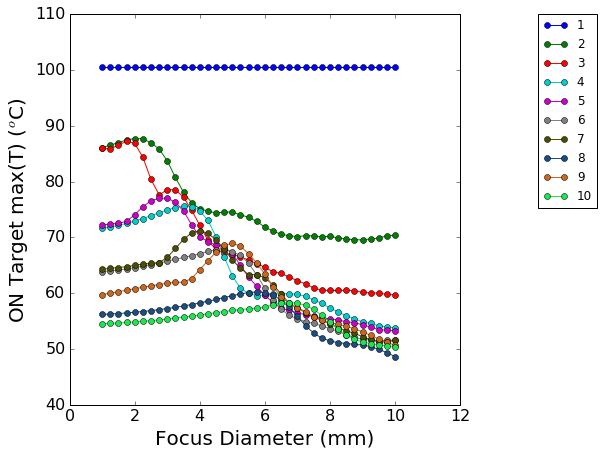

In [405]:
fig=plt.figure(figsize=(7,7))
pctChangeON = (TmaxON-T0)/(TmaxON)
pctChangeOFF = (TmaxOFF-T0)/(TmaxOFF)
pp=plt.plot( diams, (TmaxON).transpose(),'-o' )
plt.legend( nfociList,bbox_to_anchor=(1.35, 1), borderaxespad=0.)

plt.xlabel('Focus Diameter (mm)', fontsize=20)
plt.ylabel('ON Target max(T) ($^o$C)', fontsize=20)
plt.gca().tick_params(labelsize=16)

In [ ]:
pp=plt.plot( TavgRatesON.transpose(), lesionRatesAllSpace.transpose()*1e3,'-o' )
plt.legend( nfociList,bbox_to_anchor=(1.35, 1), borderaxespad=0.)

plt.xlabel('avg(max(T))', fontsize=20)
plt.ylabel('Lesion rate uL/s', fontsize=20)
plt.gca().tick_params(labelsize=16)

In [384]:
def findz(z,zarr=zrp):
    return np.where(np.logical_and( (zarr[1:-1]-z>=0) , (zarr[0:-2]-z<0) ))[0][0]

zfoci = findz(0.14)
zvals=np.array([0.11000001, 0.12, 0.13, 0.15, 0.159])
zinds = list(map(findz, zvals ))

#ratios=TavgVsZ[:,:,zinds]
ratios = np.zeros_like(TavgVsZ)
for zi in zinds:
    ratios[:,:,zi]= TavgVsZ[:,:,zi]/TavgVsZ[:,:,zfoci]

#plt.plot( zrp, TavgVsZ[3,])

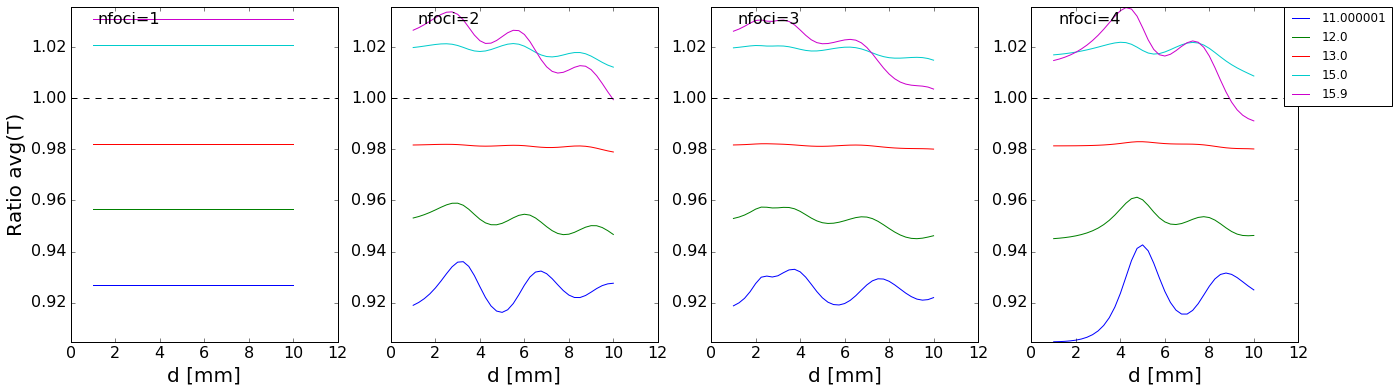

In [387]:
maxr= np.max(ratios[:,:,zinds])
minr= np.min(ratios[:,:,zinds])

plt.figure(figsize=(22,6))
axes=[]
nf=[]

mi=0
ax=plt.subplot(141, ylim=[minr,maxr] )
ax.plot(diamList*1000,  ratios[mi,:,zinds].transpose() )
ax.text(0.1,0.95,"nfoci=%d"%(mi+1),transform=ax.transAxes, fontsize=16,fontdict=dict(color='black'))


axes.append(ax)
nf.append(mi)
ax.set_ylabel('Ratio avg(T)', fontsize=20)

mi=1
ax=plt.subplot(142, ylim=[minr,maxr])
ax.plot(diamList*1000,  ratios[mi,:,zinds].transpose() )
ax.text(0.1,0.95,"nfoci=%d"%(mi+1),transform=ax.transAxes, fontsize=16,fontdict=dict(color='black'))

axes.append(ax)
nf.append(mi)

mi=2
ax=plt.subplot(143, ylim=[minr,maxr])
ax.plot(diamList*1000,  ratios[mi,:,zinds].transpose() )
ax.text(0.1,0.95,"nfoci=%d"%(mi+1),transform=ax.transAxes, fontsize=16,fontdict=dict(color='black'))
axes.append(ax)
nf.append(mi)

mi=3
ax=plt.subplot(144, ylim=[minr,maxr])
ax.plot(diamList*1000,  ratios[mi,:,zinds].transpose() )
ax.text(0.1,0.95,"nfoci=%d"%(mi+1),transform=ax.transAxes, fontsize=16,fontdict=dict(color='black'))
axes.append(ax)
nf.append(mi)

for ax in axes:
    ax.plot( ax.get_xlim(), [1.0, 1.0], 'k--')
    ax.set_xlabel('d [mm]', fontsize=20)
    #ax.set_ylabel('Ratio avg(T)', fontsize=20)
    ax.tick_params(labelsize=16)

ax.legend( zvals*100.0,bbox_to_anchor=(1.35, 1), borderaxespad=0.)

In [230]:
axes

In [102]:
#this works independent of dimensions
pmesh = np.meshgrid(nfociList,1e3*diamList,indexing='ij')
pargs=list(map( lambda *args: args, *tuple(map(lambda x: x.flatten(), pmesh)) )  )

In [11]:
import h5py

#filename="/Users/Vandiver/Data/simulations/focal_opt/focopt_roiB_L2norm_aI=30_dt=20_040518.hdf"
#f =h5py.File(filename, "w")

ablation_utils.write_xyz_simulation_coords(f, gxp=gxp, gyp=gyp,gzp=gzp,xrp=xrp,yrp=yrp,zrp=zrp,roiON=ROION,roiOFF=ROIOFF,roiEXTRA=ROIEXTRA)


names=["nfoci", "d"]
units=["", "m"]

f = ablation_utils.write_parameter_space(f, lesionRatesAllSpace, (nfociList,diamList) ,names, units=units, scoringfunc='lesionRatesAllSpace')

f['param_grid'].attrs['Ispta0']=Ispta0
f['param_grid'].attrs['alpha']=alpha
f['param_grid'].attrs['duration']=sonication_time

extnames = "lesionRatesON,lesionRatesEXTRA,lesionRatesAllSpace,TavgRatesON,TavgRatesOFF,TmaxON,TmaxOFF,TmaxSet,TavgVsZ,TWm1Set,TWm2Set".split(',')
extdata = [lesionRatesON,lesionRatesEXTRA,lesionRatesAllSpace,TavgRatesON,TavgRatesOFF,TmaxON,TmaxOFF,TmaxSet,TavgVsZ,TWm1Set,TWm2Set]

for i in range(len(extnames)):
    dset = f.create_dataset(extnames[i],data=extdata[i])
    f.flush()

f.close()

In [175]:
f =h5py.File(filename,"r")

In [176]:
list(f.keys())

['TWm1Set',
 'TWm2Set',
 'TavgRatesOFF',
 'TavgRatesON',
 'TavgVsZ',
 'TmaxSet',
 'geom',
 'lesionRatesAllSpace',
 'lesionRatesEXTRA',
 'lesionRatesON',
 'param_grid']

In [177]:
list(f['geom/gridx'].attrs.keys())

['xp']

In [178]:
f.close()

In [415]:
PBHE_CUDA.Create_Global_GPU_Session32(*T4d.shape)

T4d[0][:] = T0
CEMfinal[:] = 0
Tmax[:] = 0

(duration,Tmax, ROION, ROIOFF, ROIEXTRA) = execute_sim(4,0.004,sonication_time=60,Tmax=Tmax,alpha=3.0)

PBHE_CUDA.ResetGPU()

In [73]:
ROION=   roiGen([[0,0,0.14]], lambda x,y,z: inEllipse(x,y,z, 0.006, 0.006,0.01))

In [33]:
np.mean(Tmax[ROION]) / np.mean(Tmax[ROIOFF])

1.0549697

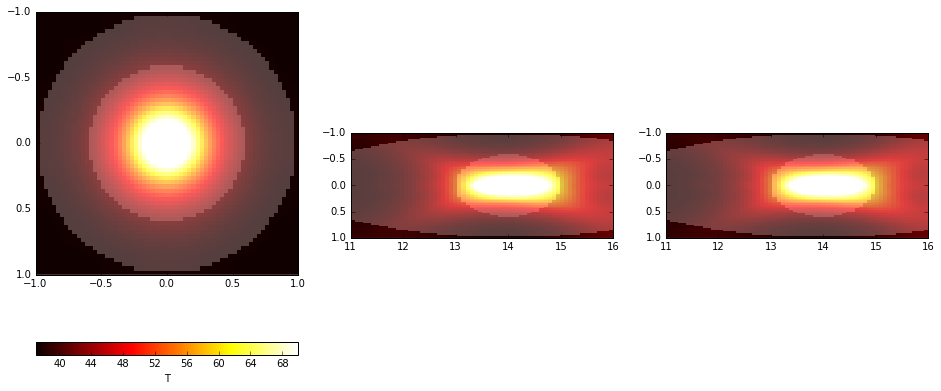

In [413]:
plt.figure(figsize=(16,8))
plt.subplot(131)
xy=list(map( lambda x: 100*x,[yrp[0],yrp[-1],xrp[-1],xrp[0]]))
plt.imshow( Tmax[:,:,focplaneZpix] , extent=xy, vmin=37,vmax=70,cmap=image.cm.hot, interpolation='none')
plt.colorbar(orientation='horizontal',label='T')
plt.imshow( ROION[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')
#plt.colorbar(orientation='horizontal',label='T')
plt.subplot(132)
yz=list(map( lambda x: 100*x,[zrp[0],zrp[-1],yrp[-1],yrp[0]]))
i=floor(Nx/2)
plt.imshow( Tmax[i,:,:] , extent=yz, vmin=37,vmax=70,cmap=image.cm.hot, interpolation='none')
plt.imshow( ROION[i,:,:] , extent=yz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[i,:,:] , extent=yz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')
plt.subplot(133)
xz=list(map( lambda x: 100*x,[zrp[0],zrp[-1],xrp[-1],xrp[0]]))
j=floor(Ny/2)
plt.imshow( Tmax[:,j,:] , extent=xz, vmin=37,vmax=70,cmap=image.cm.hot, interpolation='none')
plt.imshow( ROION[:,j,:] , extent=xz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,j,:] , extent=xz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')


In [167]:
TWcentroid=list(map(np.sum, [Tmax/np.sum(Tmax)*gxp, Tmax/np.sum(Tmax)*gyp, Tmax/np.sum(Tmax)*gzp] ))
TWm1=np.sum( Tmax/np.sum(Tmax)*np.sqrt((gxp-TWcentroid[0])**2 + (gyp-TWcentroid[1])**2 + (gzp-TWcentroid[2])**2)  )
TWm2=np.sum( Tmax/np.sum(Tmax)*((gxp-TWcentroid[0])**2 + (gyp-TWcentroid[1])**2 + (gzp-TWcentroid[2])**2)  )

In [168]:
TWm2

0.00027858586731190874

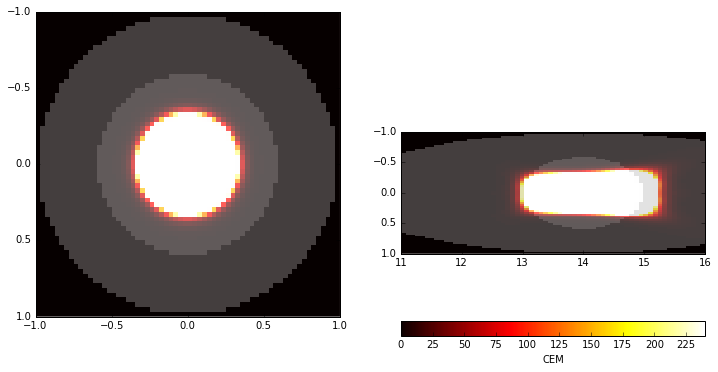

In [414]:
plt.figure(figsize=(12,8))
plt.subplot(121)
xy=list(map( lambda x: 100*x,[yrp[0],yrp[-1],xrp[-1],xrp[0]]))
plt.imshow( CEMfinal[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=240,cmap=image.cm.hot, interpolation='none')
plt.imshow( ROION[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,:,focplaneZpix] , extent=xy, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')
plt.subplot(122)
xz=list(map( lambda x: 100*x,[zrp[0],zrp[-1],xrp[-1],xrp[0]]))
j=floor(Ny/2)
plt.imshow( CEMfinal[:,j,:] , extent=xz, vmin=0,vmax=240,cmap=image.cm.hot, interpolation='none')
plt.colorbar(orientation='horizontal',label='CEM')
plt.imshow( ROION[:,j,:] , extent=xz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
plt.imshow( ROIEXTRA[:,j,:] , extent=xz, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.25, interpolation='none')


In [389]:
u,nnn=transducers.new_stipled_spherecap_array(10, 2, 9)
np.sqrt(np.sum( u**2,axis=1))

array([ 0.       ,  1.0012555,  1.0012555,  1.0012555,  1.0012555,
        1.0012555,  1.0012555,  1.0012555])

In [388]:
T4d[0][:] = T0
CEMfinal[:] = 0
Tmax[:] = 0
nnff=4
dd=0.01
tt=5
execute_sim(nnff,dd,sonication_time=tt,Tmax=Tmax,alpha=10.0)

TmHeating=T4d[0].copy()
#T4d[0][:] = T0

Tmax[:]=0
execute_sim(nnff,dd,sonication_time=tt,Tmax=Tmax,alpha=0.0)
TmCooling=T4d[0].copy()

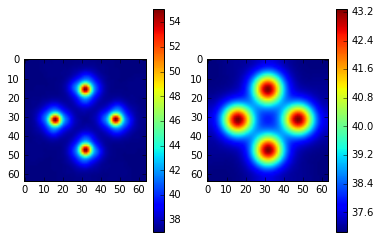

In [389]:
plt.subplot(121)
plt.imshow( TmHeating[:,:,focplaneZpix])
plt.colorbar()
plt.subplot(122)
plt.imshow( TmCooling[:,:,focplaneZpix])
plt.colorbar()

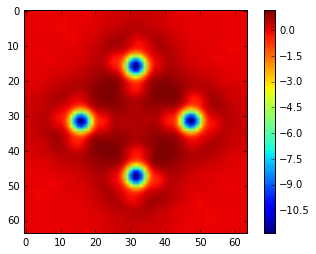

In [390]:
plt.imshow( TmCooling[:,:,focplaneZpix] - TmHeating[:,:,focplaneZpix])
plt.colorbar()

In [88]:
import scipy.interpolate as snt

In [380]:
pnts

array([[ 0.005 ,  0.    ,  0.    ],
       [-0.0025,  0.0043,  0.    ],
       [-0.0025, -0.0043,  0.    ]])

In [391]:
(pnts,junk)=geom.ring(dd,nnff)
#(pnts,junk)=geom.ring(dd,4)
xc = np.mean(pnts,axis=0)

focPlaneTc0=snt.interp2d(xrp,yrp,  TmHeating[:,:,focplaneZpix].transpose())

T0m = np.array(list(map(focPlaneTc0,pnts[:,0],pnts[:,1] ))).flatten()
RSQj = lambda i: np.sum( (pnts[i] - pnts)**2,axis=1 )
Rsqij=np.array( [RSQj(i) for i in range(0,nnff)] )


Ti = T0m*(2*pi*sigmaT**2)**(3.0/2) / np.sum( np.exp(-Rsqij/(2*sigmaT**2)), axis=1 )

D=0.6/3.7e6
sigmaT=.9e-3
tc = (1/3)*( np.sum( (xc - pnts[1])**2) - sigmaT**2 )/(2*D)

def TempCoolApprox(x,y,z,t):
    tsig = 2*D*t + sigmaT**2
    rx = x - pnts[:,0]
    ry = y - pnts[:,1]
    rz = z - pnts[:,2]
    Rsq = rx**2 + ry**2 + rz**2
    gaussmax= (2*pi*sigmaT**2)**(3.0/2.0)
    #gaussmax/(2*pi*(tsig))**(3.0/2.0)
    normterm = (1.0/(2*pi*(tsig))**(3.0/2.0))
    #normterm = gaussmax*(1.0/(2*pi*(tsig))**(3.0/2.0))/nnff
    return np.sum( [Ti[i]*np.exp(-Rsq[i]/(2*tsig) ) for i in range(0,len(Ti))] ) *normterm
    
tc

24.861944444444443

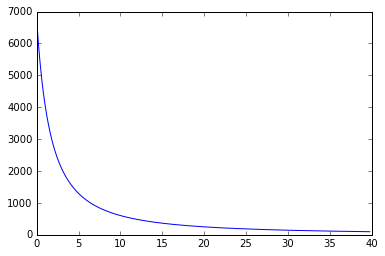

In [382]:
tt=np.arange(0.0,40,0.2)
plt.plot( tt, TempCoolApprox(0.00,0.000,0.,tt) )

In [379]:
TempCoolApprox( 0.005, 0.0, 0.0, 0)

62.043716454854973

In [381]:
T0m

array([ 62.0437,  62.6822,  62.4801])

In [394]:
#sigma weighted to Temp map around one focus
np.sqrt( np.sum( focPlaneTc0(xrp ,yrp )*( (xrp-pnts[0,0])**2 + (yrp-pnts[0,1])**2) ) / np.sum(focPlaneTc0(xrp ,yrp )) )

0.0096173195390910592

In [386]:
D=0.6/3.7e6
sigmaT=.96e-3
tc = (1/3)*( np.sum( (xc - pnts[2])**2) - sigmaT**2 )/(2*D)
tc


24.747244444444444

In [86]:
TmHeating[floor(Nx/2),floor(Ny/2),focplaneZpix]

46.678925

In [392]:
duration=40.0

interpTimes=np.arange(0.0,duration,0.2)
interpTemp = np.zeros([len(interpTimes)])
interpTempFocPlane = np.zeros([len(interpTimes), Nx,Ny])
interpTempAxial = np.zeros([len(interpTimes), Nx,Nz])

yi=floor(Ny/2)
def fdtd_interp_func(temp3d):
    tidx=fdtd_interp_func.idx  
    fdtd_interp_func.out1[fdtd_interp_func.idx] = temp3d[:,:,focplaneZpix] 
    fdtd_interp_func.out2[fdtd_interp_func.idx] = temp3d[:,yi,:] 

fdtd_interp_func.out1=interpTempFocPlane
fdtd_interp_func.out2=interpTempAxial
fdtd_interp_func.idx=0

pbheDict = dict(Ntbuff=Nt, GPU=False, Freeflow=1, interpTimes=interpTimes, interpolatedTemp=interpTemp, interpFunc=fdtd_interp_func)


T4d[0] = TmHeating
tdot3d[:]=0.0
ablation_utils.calc_heating(simgrid,T4d, tdot3d, simgrid['Tmesh'], simgrid['Tdotmesh'], simgrid['kmesh'], simgrid['rhoCpmesh'], duration, CEMfinal,Rbase,   
                                                      **pbheDict)

(40.000000596046448, None, None, None)

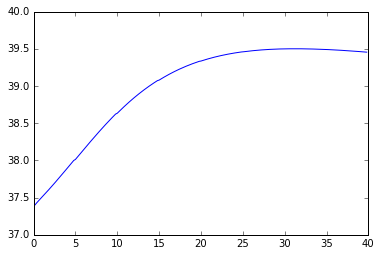

In [393]:
plt.plot(interpTimes,interpTempFocPlane[:,floor(Nx/2),floor(Ny/2)])

In [453]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [253]:
(un_r, un_theta, un_phi) = geom.cart2sphere(u[:,0], u[:,1], u[:,2])

In [304]:
Rn = geom.getRotZYZarray(0.05, pi, 0)

In [305]:
v = u.dot(Rn)

In [458]:
(vxyz,ns,(arr1,arr2))=transducers.subsample_transducer_array(uxyz, 0.0033,21,unormvecs=unvecs,ROC=0.14, arrays_to_grow=[uamp0,unvecs])

In [55]:
ablation_utils.countSonications(10,4,0,0.7,2.0,2.0)

36.0

In [429]:
tuple(list(uxyz.shape))

(256, 3)

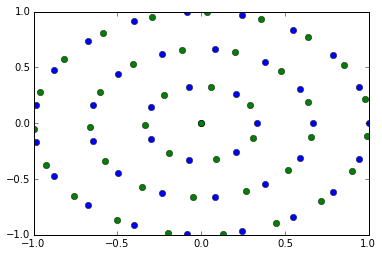

In [306]:
plt.plot(u[:,0], u[:,1],'o')
plt.plot(v[:,0], v[:,1],'o')

In [248]:
from mpl_toolkits.mplot3d import Axes3D

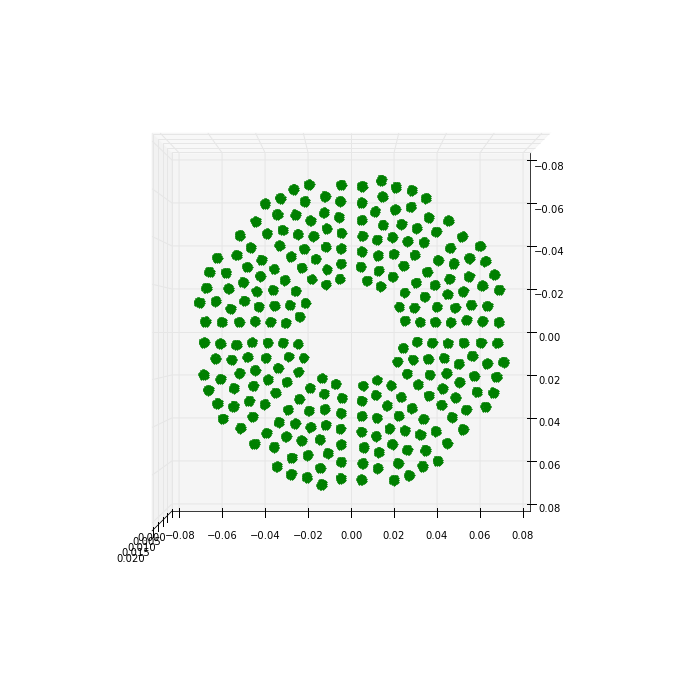

In [363]:
fig = plt.figure(figsize=(12,12), dpi=72)
ax = fig.gca(projection='3d')
ax.set_zlim(top=0.02)
ax.plot3D(uxyz[:,0], uxyz[:,1], uxyz[:,2],'.')
ax.plot3D(vxyz[:,0], vxyz[:,1], vxyz[:,2],'.')
ax.view_init(90,0)

In [1]:
import numpy as np
import sys
from math import *

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import image

%matplotlib inline

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')

import geom
import transducers
import sonalleve
import RSgpuPySwig

import PBHE_CUDA
import sys
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import importlib

In [23]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [428]:
xpp = np.arange(-0.01,0.01,0.0001)
#xpp=np.array([0.0])
#xpp=[0.0]
ypp = xpp
ypp=[0.0]
zpp = np.arange(0.07,0.16,0.0001)
#zpp=[0.14]
f0=1.2e6
c0=1540
k0=2*pi*f0/c0
rho=1000
uxyz = sonalleve.get_sonalleve_xdc_vecs()
N = uxyz.shape[0]

unvecs = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)), 1, [0.0,0.0,0.14] - uxyz )



In [27]:
len(xpp)*len(zpp)*len(ypp)

40000

In [448]:
transducers.new_stipled_spherecap_array(0.14,0.0066,232)

[array([[ 0.    ,  0.    ,  0.    ],
        [ 0.0004,  0.    ,  0.    ],
        [ 0.0003,  0.0003,  0.    ],
        [-0.0001,  0.0004,  0.    ],
        [-0.0004,  0.0002,  0.    ],
        [-0.0004, -0.0002,  0.    ],
        [-0.0001, -0.0004,  0.    ],
        [ 0.0003, -0.0003,  0.    ],
        [ 0.0008,  0.    ,  0.    ],
        [ 0.0007,  0.0004,  0.    ],
        [ 0.0005,  0.0007,  0.    ],
        [ 0.0001,  0.0008,  0.    ],
        [-0.0003,  0.0008,  0.    ],
        [-0.0006,  0.0005,  0.    ],
        [-0.0008,  0.0002,  0.    ],
        [-0.0008, -0.0002,  0.    ],
        [-0.0006, -0.0005,  0.    ],
        [-0.0003, -0.0008,  0.    ],
        [ 0.0001, -0.0008,  0.    ],
        [ 0.0005, -0.0007,  0.    ],
        [ 0.0007, -0.0004,  0.    ],
        [ 0.0012,  0.    ,  0.    ],
        [ 0.0012,  0.0004,  0.    ],
        [ 0.001 ,  0.0008,  0.    ],
        [ 0.0007,  0.001 ,  0.    ],
        [ 0.0003,  0.0012,  0.    ],
        [-0.0001,  0.0012,  0.    ],
 

In [ ]:
#pxyz,radius = geom.ring(d,M,z=0.14)
pxyz=[[-0.002, 0.0, 0.14], [0.002, 0.0, 0.14]]
M=len(pxyz)
uamp = transducers.get_focused_element_vals( k0,uxyz,pxyz, np.ones(M), L1renorm=1.0e4 )

uamp0 = np.ones(256)

Pse = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xpp, ypp, zpp, subsampN=9, subsampDiam=0.0066, ROC=0.14, gpublocks=64)
Ise = np.abs(Pse)**2 / (2.0*rho*c0)

Pss = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xpp, ypp, zpp, subsampN=232, subsampDiam=0.0066, ROC=0.14, gpublocks=64)
Iss = np.abs(Pss)**2 / (2.0*rho*c0)

#Ise /= np.max(Ise)
#Iss /= np.max(Iss)


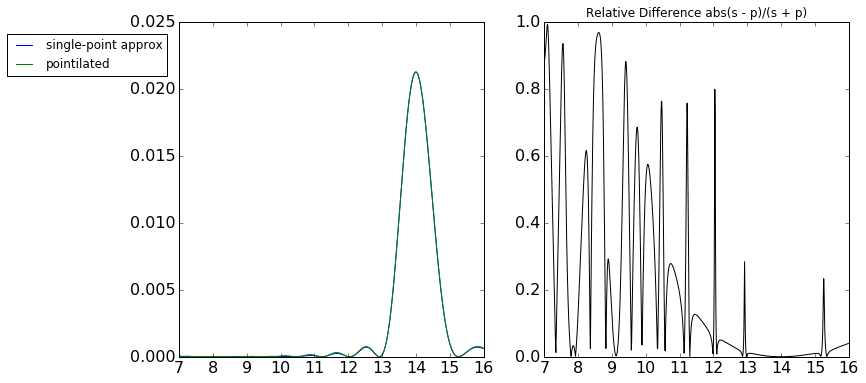

In [442]:
plt.figure(figsize=(12,6))
i=floor(len(xpp)/2)
j=floor(len(ypp)/2)
k=floor(len(zpp)/2)
plt.subplot(121)
ax=plt.gca()
ax.tick_params(labelsize=16)
plt.plot(100*zpp,Ise[i,j,:])
plt.plot(100*zpp,Iss[i,j,:])
plt.legend(['single-point approx', 'pointilated'], bbox_to_anchor=(0.0, 1), borderaxespad=1.)
plt.subplot(122)
plt.plot(100*zpp,  np.abs(Ise[i,0,:] - Iss[i,0,:]) /(Ise[i,0,:] + Iss[i,0,:]) ,'k-')
ax=plt.gca()
ax.tick_params(labelsize=16)
ax.set_title('Relative Difference abs(s - p)/(s + p)')

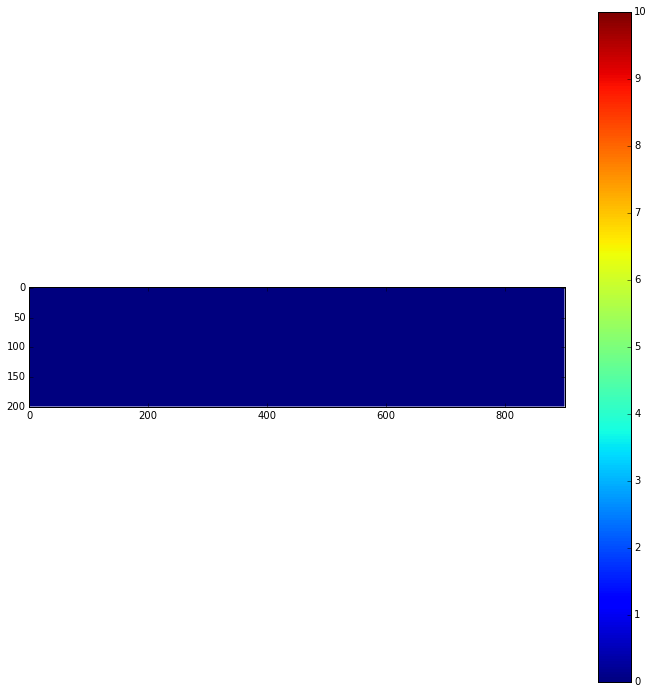

In [51]:
plt.figure(figsize=(12,12))
plt.imshow((Ise[:,0,:] - Iss[:,0,:]) /  (Iss[:,0,:]) ,vmax=10, interpolation='none' )
plt.colorbar()

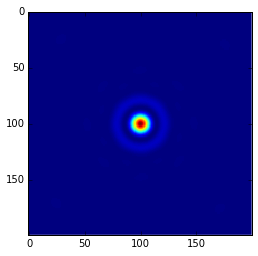

In [36]:
plt.imshow(Iss[:,:,k] , interpolation='none' )

In [12]:
path=np.array([xpp,np.zeros_like(xpp),np.ones_like(xpp)*0.14]).transpose()
Pcpu = transducers.calc_pressure_profile(k0, uxyz, uamp, path)
Icpu = np.abs(Pcpu)**2 / (2.0*rho*c0)

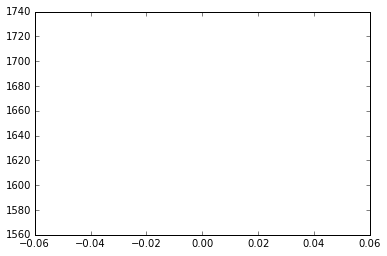

In [13]:
plt.plot(Icpu)

In [39]:
nnn=30
testarr=np.arange(0,nnn)
(uxyz,ns,(testarrnew,))=transducers.subsample_transducer_array( uxyz[0:nnn,:], 0.0033, 10,arrays_to_grow=[testarr] )

In [34]:
testarrnew

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5])

In [35]:
ns

8

In [40]:
sum(testarr)

435

In [41]:
sum(testarrnew)/ns

435.0

In [16]:
import timeit

In [17]:
def ver1():
    transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, gpublocks=0)
    
def ver2():
    transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp, xrp, yrp, zrp, gpublocks=256, subsampN=20, subsampDiam=0.0033,ROC=0.14)

In [18]:
timeit.timeit( ver2,number=1)

7.227584454457917

In [ ]:
timeit.timeit( ver2,number=1)

In [42]:
256*Nx*Ny*Nz / 2251

32753.44291426033

In [44]:
16535*2

33070

In [57]:
10240*Nx*Ny*Nz / 33070

NameError: name 'Nx' is not defined

In [51]:
2251/40

56.275

NameError: name 'T' is not defined

In [60]:
q=np.zeros([2,3])

In [61]:
q.ndim

2

In [62]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()

In [64]:
uxyz.ndim

2

In [68]:
1 %1

0

In [87]:
def innerf(a=0,b=0):
    print(a,b)

def outer(x,**kwas):
    print (kwas['a'])
    innerf(**kwas)

1 0


In [88]:
outer(1,a=4)

4
4 0


In [92]:
np.zeros(2,dtype=bool)

array([False, False], dtype=bool)

In [93]:
10%1

0